In [1]:
import sys
sys.path.append('../scripts')

import proplot as pplt
import pandas as pd
from helpers import *
from scipy import stats
import numpy as np
import random

In [2]:
def varClassifier(df, var, newcol, intervals : list[tuple]):
    for i, interval in enumerate(intervals):
        df.loc[np.logical_and(df[var] >= interval[0], df[var] < interval[1]), newcol] = i
    df = df.dropna()
    df = df.astype({newcol: int})
    return df

In [3]:
def parseData(buoy):
        df = era5_data(buoy)
        df.datetime = df.datetime.astype("datetime64[s]")
        df.index = df.datetime

        dt = pd.Series(df.datetime) - pd.Series(df.datetime).shift()
        dt = dt.dt.total_seconds()

        vx = (df.x_stere - df.x_stere.shift())/dt
        vy = (df.y_stere - df.y_stere.shift())/dt
        v = np.sqrt(vx**2 + vy**2)
        wind_vel = np.sqrt(df['10m_u_wind_mps']**2 + df['10m_v_wind_mps']**2)

        df = df.drop(columns=["10m_u_wind_mps","10m_v_wind_mps"])

        df = df.assign(drift_speed_mps = v, wind_speed_mps=wind_vel).dropna()
        df["drift_ratio"] = df["drift_speed_mps"]/df["wind_speed_mps"]
        df["dep_leg"] = buoy_metadata(buoy)["Deployment Leg"]
        df["buoy_id"] = buoy

        return df

In [26]:
def plotJoint(df, var1, var2, categories,
              bins, *, xlims=[], ylims=[], overlay_slope=0.015, ncols=1):

    main_cats = list(categories.keys())
    vars = df[[var1, var2, *main_cats]]
    groups = vars.groupby(main_cats)

    ncols = df[main_cats[-1]].nunique()
    nrows = (len(groups)-1)//ncols + 1
    fig, axs = pplt.subplots(ncols=ncols, nrows=nrows, figsize=(14,nrows*(10/ncols)), share=False)
    colormap = pplt.Colormap(["white"]+["blue"]*2)

    xbounds = xlims
    ybounds = ylims

    for i, group in enumerate(groups):
        title = group[0]
        data = group[1]

        if len(xlims) != 2:
            xbounds = [data[var1].min(), data[var1].max()]
        if len(ylims) != 2:
            ybounds = [data[var2].min(), data[var2].max()]

        x_bins = np.linspace(*xbounds, bins[0])
        y_bins = np.linspace(*ybounds, bins[1])

        x_center, y_center = 0.5*(x_bins[1:] + x_bins[:-1]), 0.5*(y_bins[1:] + y_bins[:-1])
        
        binned = np.histogram2d(data[var1], data[var2], bins=[x_bins, y_bins])[0]
        binned = pd.DataFrame(binned, index=x_center, columns=y_center)

        c = axs[i].contour(binned.T, cmap=colormap, discrete=True)

        ax_identifier = " ".join([categories[key][idx] for key, idx in zip(main_cats, title)])
        axs[i].format(title=ax_identifier, xlocator="linear", xlabel=var1, ylabel=var2)

        overlay = x_center * overlay_slope
        axs[i].plot(x_center, overlay, color="red")

    return binned

In [5]:
def summaryStats(groups, columns, categories):
    summaries=[]
    vars = df[[*columns, *categories]]
    groups = vars.groupby(categories[::-1])
    
    for i, group in enumerate(groups):
        data = group[1]
        summary = {}

        for var in categories:
            summary[var] = data.iloc[0][var]
        
        for var in columns:
            summary[f"{var} 0.25q"] = data[var].quantile(0.25)
            summary[f"{var} median"] = data[var].quantile(0.5)
            summary[f"{var} 0.75q"] = data[var].quantile(0.75)
    
        summary["num_obs"] = len(data)
        summaries.append(pd.DataFrame(summary, index=[str(group[0])]))
    return pd.concat(summaries, axis=0).reset_index(drop=True)

In [6]:
def makeHist(df, var, *, categories, overlays, num_bins, lims=[]):
    if len(lims) != 2:
        lims = [0, df[var].max()]
    bins = np.linspace(*lims, num_bins)

    main_cats = list(categories.keys())[::-1]
    overlay_cats = list(overlays.keys())

    vars = df[[var, *main_cats, *overlay_cats]]
    groups = vars.groupby(main_cats)
    
    fig, ax = pplt.subplots(figsize=(10,len(groups)*3), nrows=len(groups), sharex=False)
    for i, group in enumerate(groups):
        group_name, group_data = group

        overlay_groups = group_data.groupby(overlay_cats)
        for overlay_group_name, overlay_group_data in overlay_groups:
            overlay_identifier = " ".join([overlays[key][idx] for key, idx in zip(overlay_cats, overlay_group_name)])
            ax[i].hist(overlay_group_data[var], 
                       bins=bins, 
                       label=overlay_identifier,
                       histtype="step", lw=3,
                       weights=np.ones(len(overlay_group_data)) / len(overlay_group_data))
        ax_identifier = " ".join([categories[key][idx] for key, idx in zip(main_cats, group_name)])
        ax[i].format(title=ax_identifier, xlocator="linear", xlabel=f"{var}", ylabel="freq")
        ax[i].legend()

In [49]:
season_ranges = [
    (pd.to_datetime("2019-09-01"), pd.to_datetime("2019-11-30")),
    (pd.to_datetime("2019-11-30"), pd.to_datetime("2020-03-31")),
    (pd.to_datetime("2020-03-31"), pd.to_datetime("2020-05-30")),
    (pd.to_datetime("2020-05-30"), pd.to_datetime("2020-10-30"))
]
wind_ranges = [(0,3), (3,7), (7,100)]
cloud_ranges = [(0,95), (95, 101)]

seasons = ["Freezing", "Winter", "Melting", "Summer"]
wind_levels = ["Low Wind", "Medium Wind", "High Wind"]
cloud_covers = ["Clearish", "Cloudy"]

meta = buoy_metadata()
valid_buoys = meta[meta["Interp"]==True]

dn1_buoys = valid_buoys[valid_buoys["Deployment Leg"] != 5].index
dn2_buoys = valid_buoys[valid_buoys["Deployment Leg"] == 5].index

buoy_data_list = [] # pd.concat([parseData(buoy) for buoy in dn1_buoys]).reset_index(drop=True)

season_data_cutoffs = [1200, 2900, 1200, 2900]
for buoy in dn1_buoys:
    data = parseData(buoy).set_index("datetime")
    for i, r in enumerate(season_ranges):
        num_obs = len(data[r[0]:r[1]])
        if num_obs < 1000:
            data.drop(index=data[r[0]:r[1]].index)
    buoy_data_list.append(data)
df = pd.concat(buoy_data_list)
df = df.reset_index()

df = varClassifier(df, "datetime", "season", season_ranges)
df = varClassifier(df, "total_cloud_cover", "cloud_cover", cloud_ranges)
df = varClassifier(df, "wind_speed_mps", "wind_level", wind_ranges)

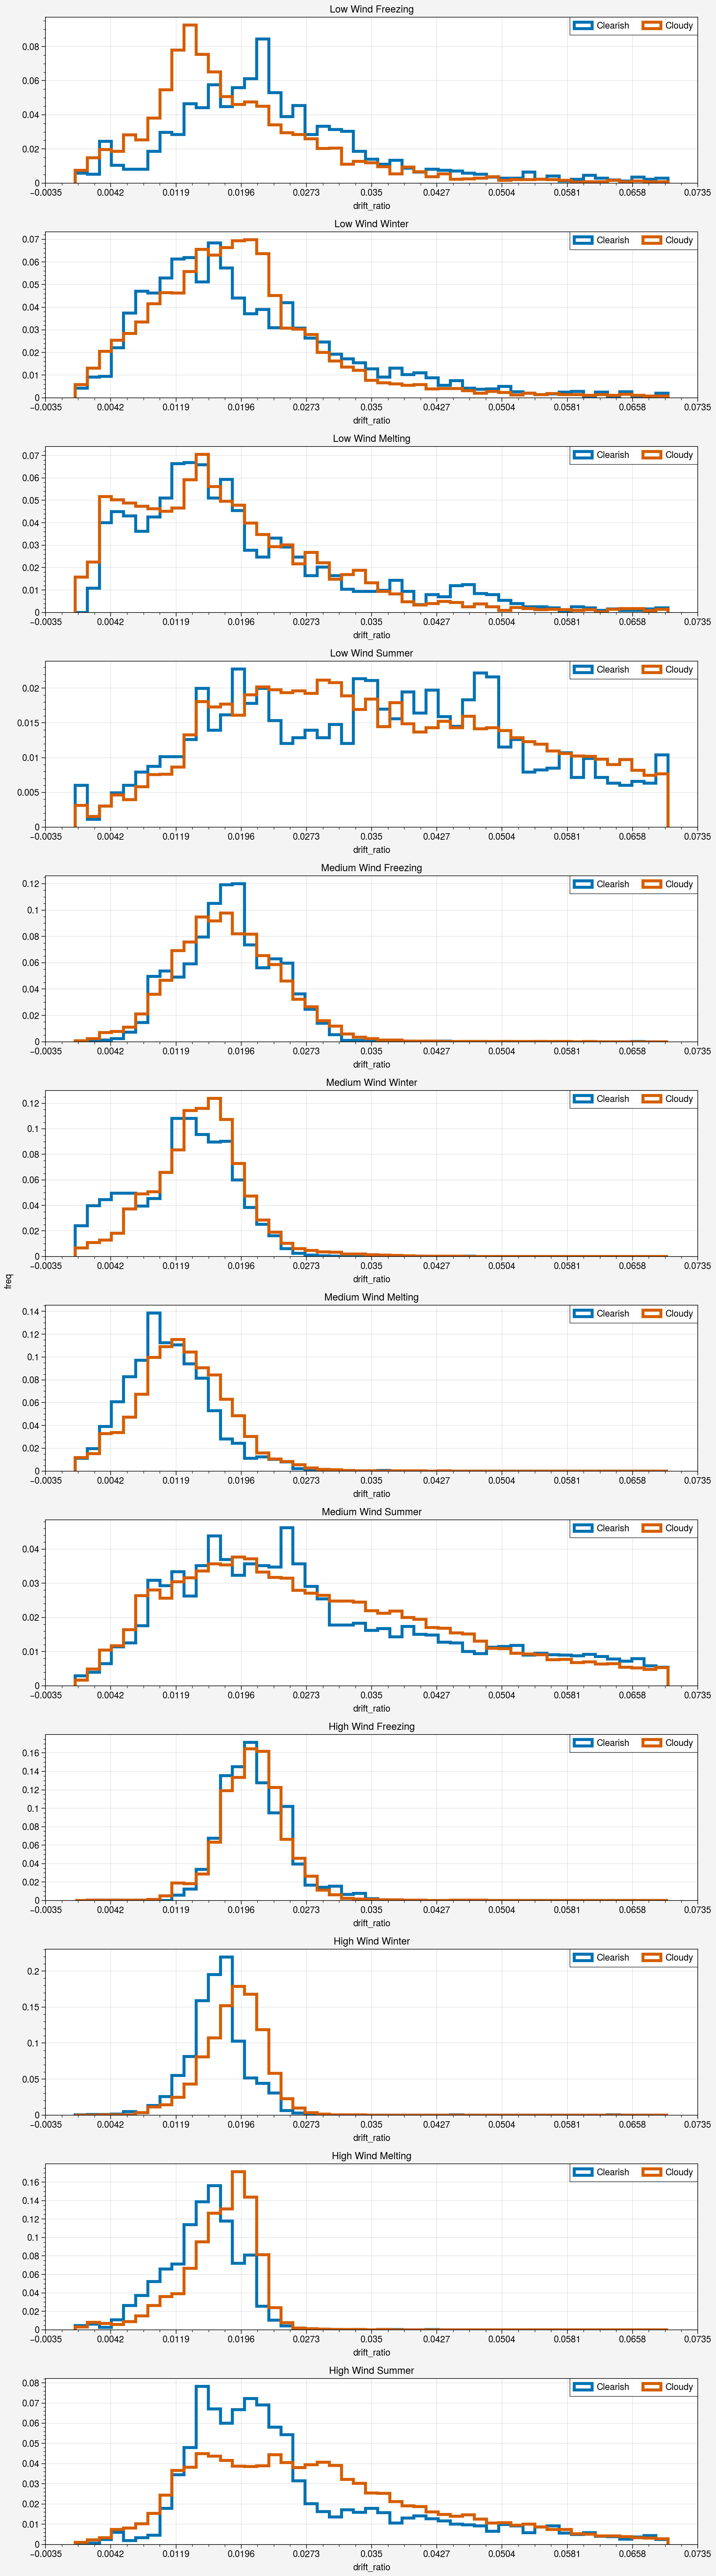

In [50]:
makeHist(df, "drift_ratio", 
         categories = {"season": seasons, "wind_level": wind_levels}, 
         overlays = {"cloud_cover": cloud_covers}, 
         num_bins=50, lims=[0,0.07])

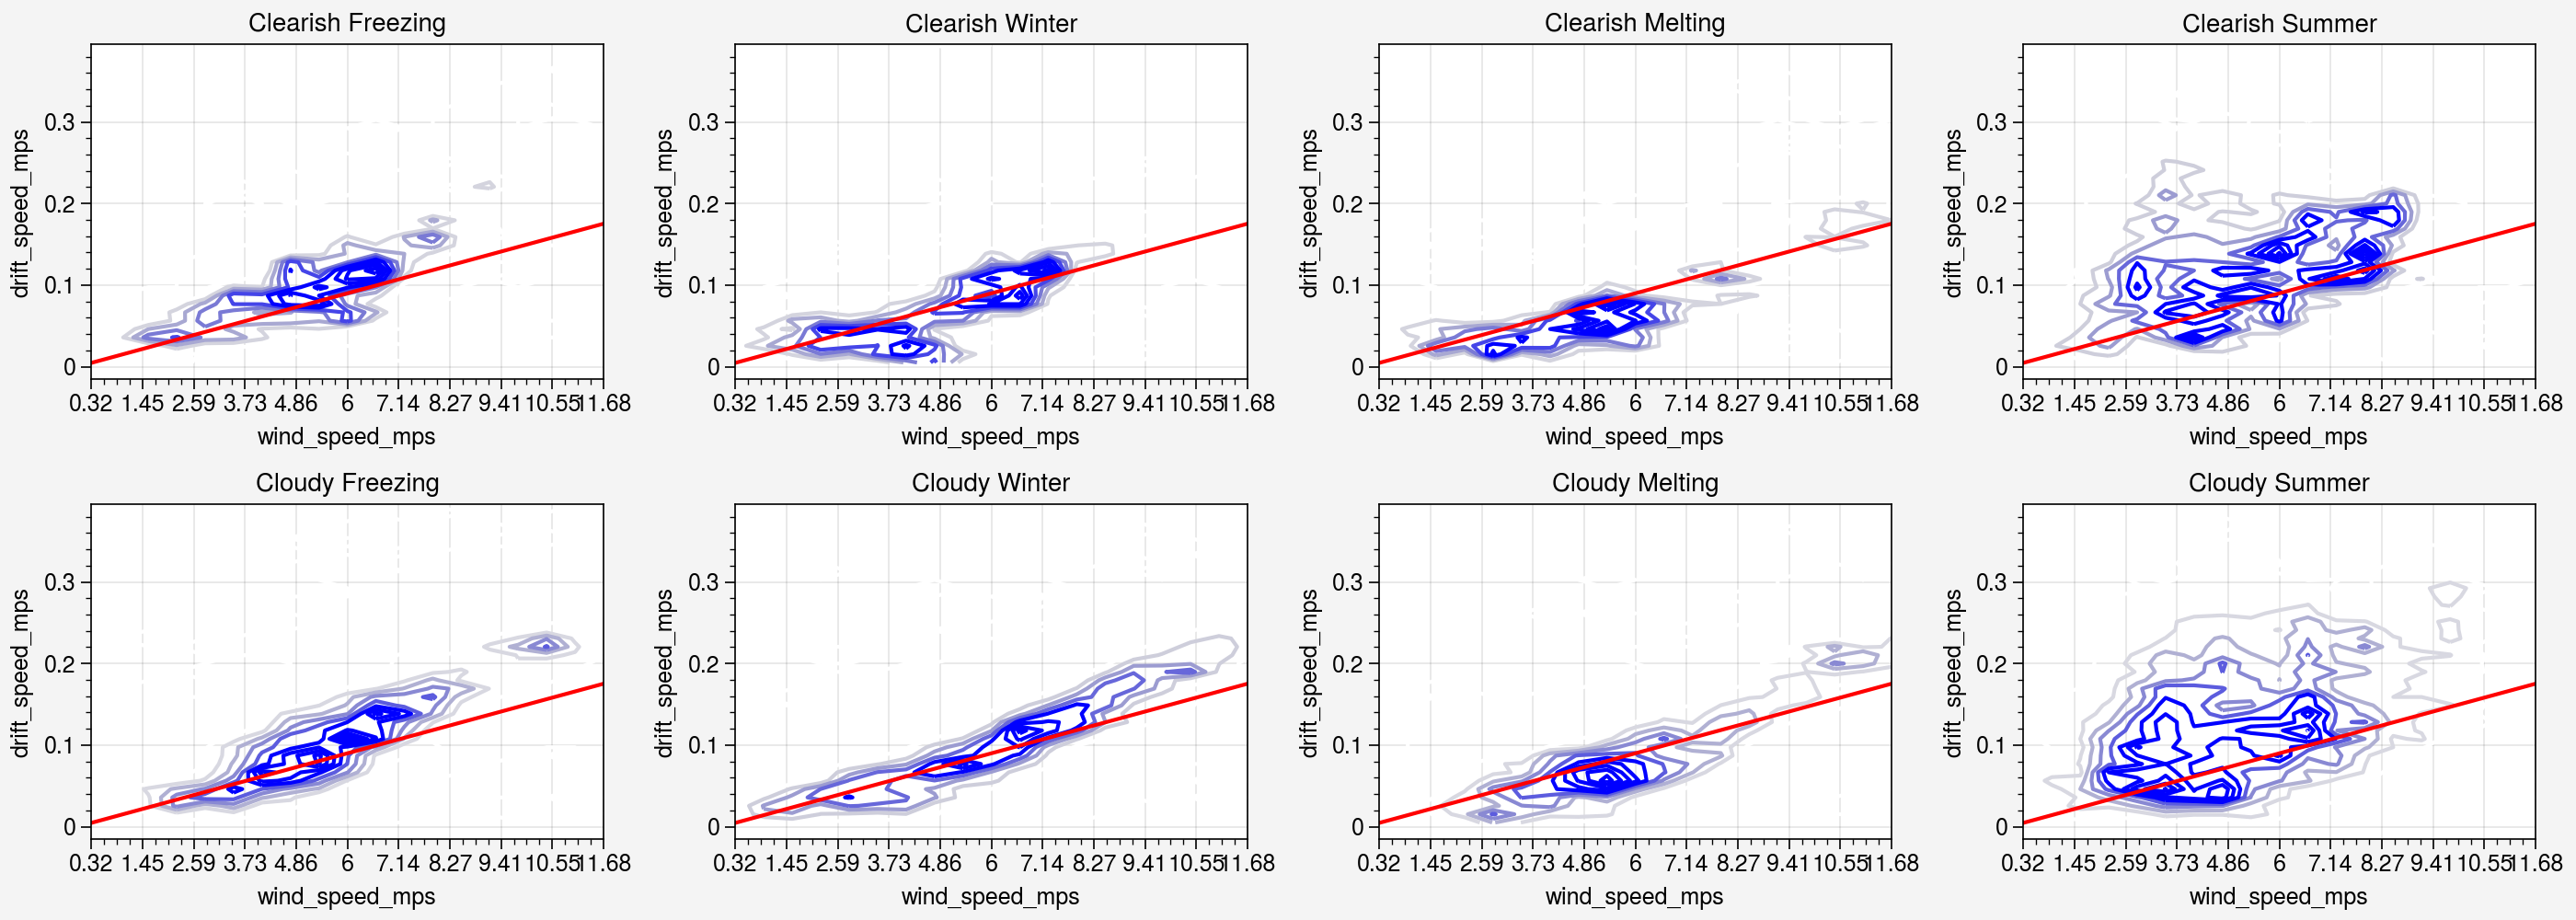

In [47]:
binned = plotJoint(df, "wind_speed_mps", "drift_speed_mps", 
                   categories = {"cloud_cover": cloud_covers, "season": seasons}, 
                   bins=[20,40], xlims=[0,12], ylims=[0,0.4])


In [28]:
print(summaryStats(df, ["drift_ratio"], ["cloud_cover", "season", "wind_level"]))

,cloud_cover,season,wind_level,drift_ratio 0.25q,drift_ratio median,drift_ratio 0.75q,num_obs
0,0.0,0.0,0.0,0.016340,0.022327,0.030750,1718
1,1.0,0.0,0.0,0.012322,0.016813,0.024650,3514
2,0.0,1.0,0.0,0.011925,0.017880,0.027044,4521
3,1.0,1.0,0.0,0.012527,0.018373,0.023915,12116
4,0.0,2.0,0.0,0.010982,0.016566,0.026315,2021
5,1.0,2.0,0.0,0.008933,0.015669,0.023688,4259
6,0.0,3.0,0.0,0.030274,0.050232,0.103693,3652
7,1.0,3.0,0.0,0.028934,0.050922,0.095237,14333
8,0.0,0.0,1.0,0.014539,0.018046,0.021854,7901
9,1.0,0.0,1.0,0.013796,0.017643,0.021933,26261


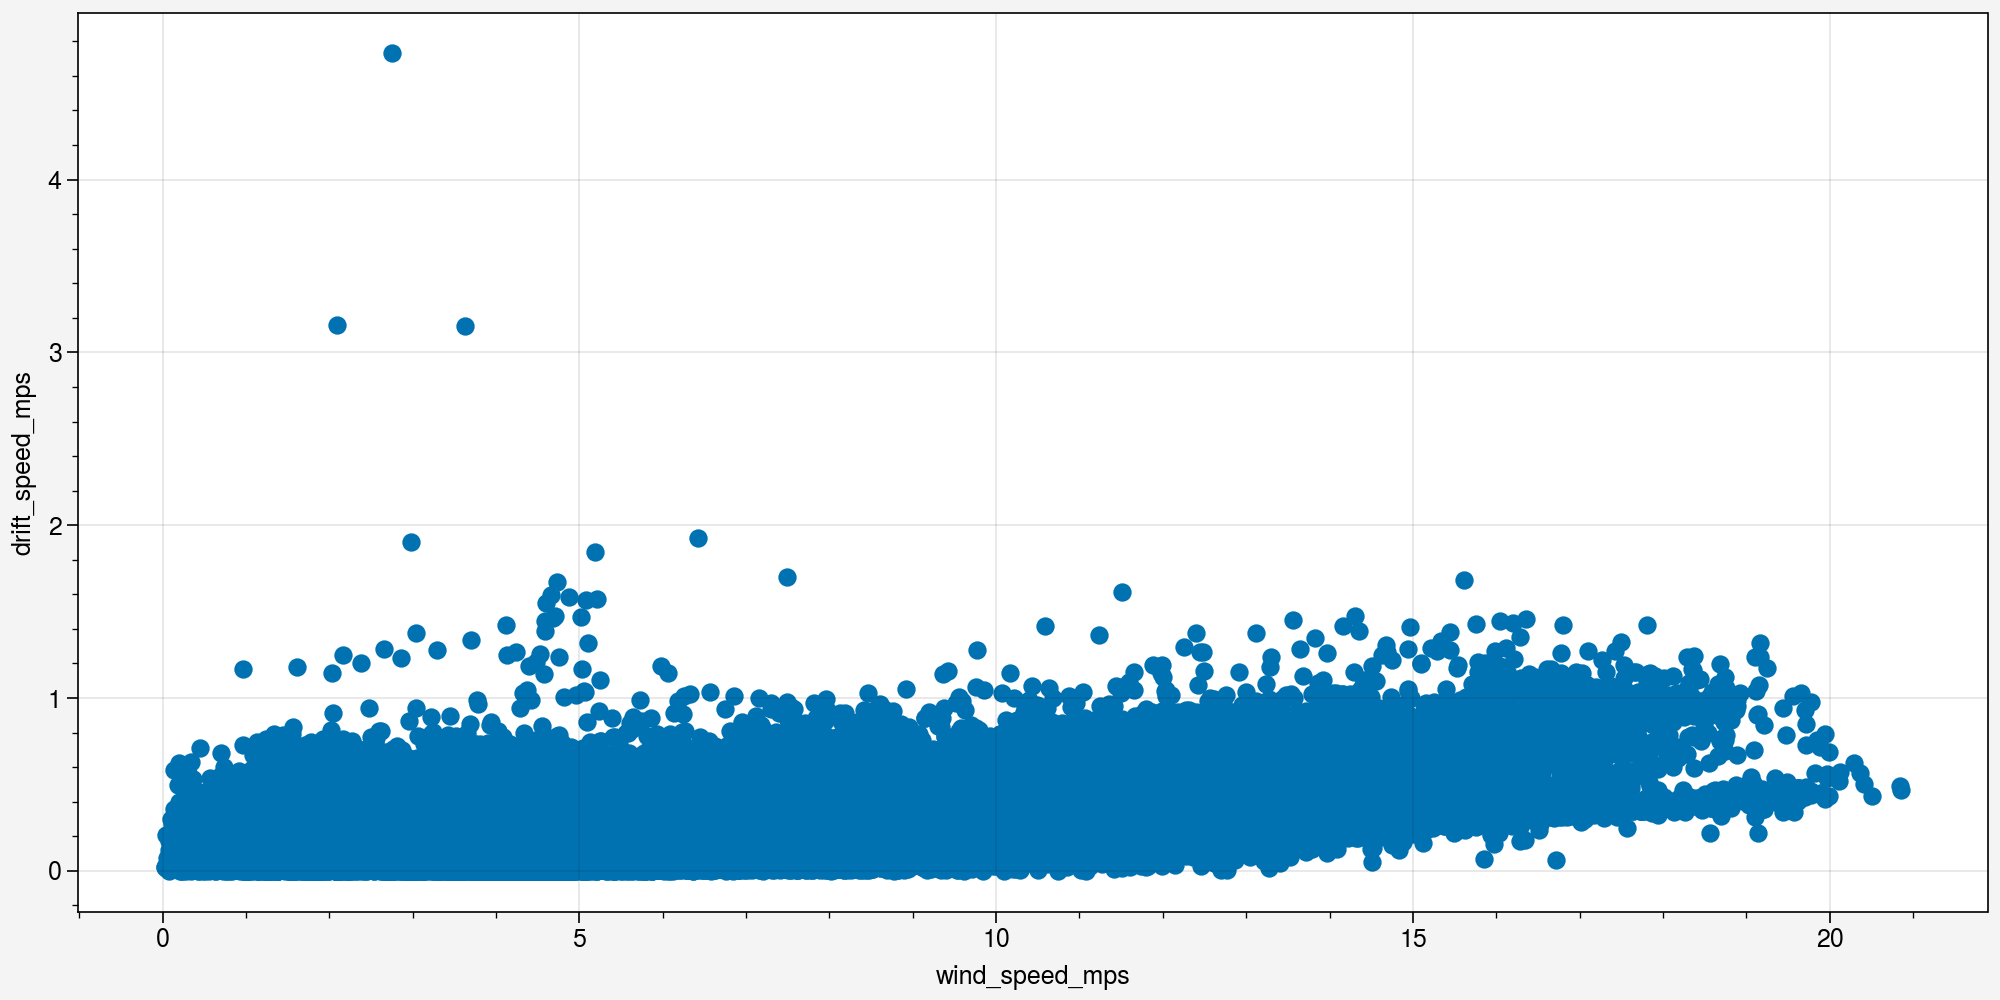

In [9]:
fig, ax = pplt.subplots(figsize=(10,5))
ax.scatter(df.wind_speed_mps, df.drift_speed_mps)

# Next steps
1. Data grouping.
   * Pick date ranges to account for the changes in location, season and ice thickness. Freeze-up, winter, thaw, and summer. Dn2 separately.
   * Pick subsets of buoys so that you have the about the same number of observations for each day within a group. (Later: we can downsample to avoid having buoys that are clustered too closely)
2. For data display, consider using overlapping contour plots (so you can e.g. see the clear-sky and cloudy-sky data in one panel).
3. To highlight the differences between distributions, we can use "cross sections" - group the drift speed ratios by wind speed categories, and compare the distributions of clear and cloudy skies for each time section.
4. Make a map showing the trajectories for each date range. One map, color to show the date ranges. I can help with zooming in on the map and adding sea ice concentration. Do this in the "Buoy Processing.ipynb"